# Image Generation with IP-Adapter XL (SDXL)

This notebook demonstrates how to use the DEGIS package to:
1. Load trained color head models
2. Set up IP-Adapter XL with ControlNet for high-quality image generation
3. Generate images using color and layout control with SDXL

Based on the ablation notebook but using IP-Adapter XL for higher quality results.


## 1. Setup and Install Dependencies


In [25]:
# # Install IP-Adapter and dependencies
# %pip uninstall -y ip-adapter diffusers
# %pip install --no-cache-dir git+https://github.com/Ahmed-Sherif-ASA/IP-Adapter@main
# %pip install diffusers


## 2. Imports and Setup


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from IPython.display import display
import os
import glob

# Import the DEGIS package
import degis
from degis.data.dataset import UnifiedImageDataset
# from degis.config import csv_path, embeddings_path, colour_path, precomputed_adimagenet_edge_maps_path

# Import IP-Adapter XL
import ip_adapter
from ip_adapter import IPAdapterXL
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline
from degis.features.color_histograms import compute_color_histogram
import geomloss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 3. Load Data and Models


In [39]:
csv_path = "/data/thesis/laion_5m_manifest.csv"
embeddings_path = "/data/thesis/models/hf_xl_laion_5m_embeddings.npy" # || YOUR_CUSTOM_PATH
colour_path = "/data/thesis/data/laion_5m_color_histograms_rgb_512.npy" # options: COLOR_HIST_PATH_LAB_514 || COLOR_HIST_PATH_RGB || YOUR_CUSTOM_PATH
colour_head_checkpoint_path = "/data/degis/runs/color_rgb512_tk20_b128-20250907-020145/best_color_head_tmp.pth" # || YOUR_CUSTOM_PATH
precomputed_adimagenet_edge_maps_path = "/data/thesis/data/adimagenet_edge_maps.npy" # || YOUR_CUSTOM_PATH


# ip_ckpt = "/data/thesis/models/ip-adapter_sd15.bin"
image_encoder_path = "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
controlnet_id = "diffusers/controlnet-canny-sdxl-1.0"
# stable_diffusion_model_id = "runwayml/stable-diffusion-v1-5"

In [40]:
# Load datasets
df = pd.read_csv(csv_path)
colour_dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",
    size=(224, 224),
    subset_ratio=1.0
)

# Load precomputed data
embeddings = np.load(embeddings_path, mmap_mode="r").astype(np.float32, copy=False)
histograms = np.load(colour_path, mmap_mode="r").astype(np.float32, copy=False)
edge_maps = np.load(precomputed_adimagenet_edge_maps_path, mmap_mode="r")

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Loaded histograms: {histograms.shape}")
print(f"Loaded edge maps: {edge_maps.shape}")

# Load trained color head
color_head = degis.load_trained_color_head(
    checkpoint_path=colour_head_checkpoint_path,
    clip_dim=embeddings.shape[1],
    hist_dim=histograms.shape[1],
    device=device
)
print("✓ Color head loaded successfully")


Loaded embeddings: (3336240, 1280)
Loaded histograms: (3336240, 512)
Loaded edge maps: (2080, 50176)
✓ Color head loaded successfully


## 4. Setup IP-Adapter XL Pipeline


In [41]:
# Setup cache directory
HF_CACHE = "/data/hf-cache" if os.path.exists("/data") else "./hf-cache"
os.makedirs(HF_CACHE, exist_ok=True)

os.environ["HF_HOME"] = HF_CACHE
os.environ["HUGGINGFACE_HUB_CACHE"] = os.path.join(HF_CACHE, "hub")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(HF_CACHE, "transformers")
os.environ["DIFFUSERS_CACHE"] = os.path.join(HF_CACHE, "diffusers")
os.environ["TORCH_HOME"] = os.path.join(HF_CACHE, "torch")

print(f"Using cache directory: {HF_CACHE}")

# Create IP-Adapter XL generator
generator = degis.IPAdapterXLGenerator(device=device)

# Setup the pipeline
generator.setup_pipeline(
    model_id="stabilityai/stable-diffusion-xl-base-1.0",
    controlnet_id=controlnet_id,
    ip_ckpt=None,  # Update path as needed
    image_encoder_path=image_encoder_path,
    cache_dir=HF_CACHE,
    torch_dtype=torch.float16,
)

print("✓ IP-Adapter XL pipeline setup complete")


Using cache directory: /data/hf-cache


Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

IP-Adapter sdxl checkpoint not found at h94/IP-Adapter
✓ Downloaded IP-Adapter sdxl checkpoint


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ IP-Adapter XL pipeline setup complete


## 5. Image Generation Functions


In [30]:
def generate_from_dataset_id_xl(
    colour_index: int,
    layout_index: int,
    prompt: str = "a cat playing with a ball",
    guidance_scale: float = 6.5,
    steps: int = 40,
    controlnet_conditioning_scale: float = 0.8,
    num_samples: int = 1,
    attn_ip_scale: float = 0.8,
    text_token_scale: float = 1.0,
    ip_token_scale: float = None,
    ip_uncond_scale: float = 0.0,
    zero_ip_in_uncond: bool = True,
):
    """Generate images using IP-Adapter XL with advanced controls."""
    
    # Get original image for display
    img_t, _ = colour_dataset[colour_index]
    pil_img = transforms.ToPILImage()(img_t)
    
    # Get CLIP embedding and compute color embedding
    z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
    color_embedding = degis.get_color_embedding(color_head, z_clip)
    
    # Create control image from edge data
    control_image = degis.create_edge_control_image(edge_maps[layout_index], size=512)
    
    # Generate images with IP-Adapter XL
    images = generator.generate(
        color_embedding=color_embedding,
        control_image=control_image,
        prompt=prompt,
        negative_prompt=(
            "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, "
            "sketch, cartoon, drawing, anime:1.4, comic, illustration, posterized, "
            "mosaic, stained glass, abstract, surreal, psychedelic, trippy, texture artifact, "
            "embroidery, knitted, painting, oversaturated, unrealistic, bad shading"
        ),
        num_samples=num_samples,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        # IP-Adapter XL specific parameters
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=ip_token_scale,
        ip_uncond_scale=ip_uncond_scale,
        zero_ip_in_uncond=zero_ip_in_uncond,
    )
    
    # Display results
    comparison = degis.display_comparison_grid(
        original=pil_img,
        control=control_image,
        generated=images,
        cols=3
    )
    display(comparison)
    
    return images

print("✓ IP-Adapter XL generation function defined")


✓ IP-Adapter XL generation function defined


## 6. Generate High-Quality Images


Generating images with IP-Adapter XL (SDXL)...
Debug get_color_embedding:
  - Input shape: torch.Size([1, 1280])
  - Logits shape: torch.Size([1, 512])
  - Probs shape: torch.Size([1, 512])
  - Color embedding shape: torch.Size([1, 1280])


  0%|          | 0/40 [00:00<?, ?it/s]

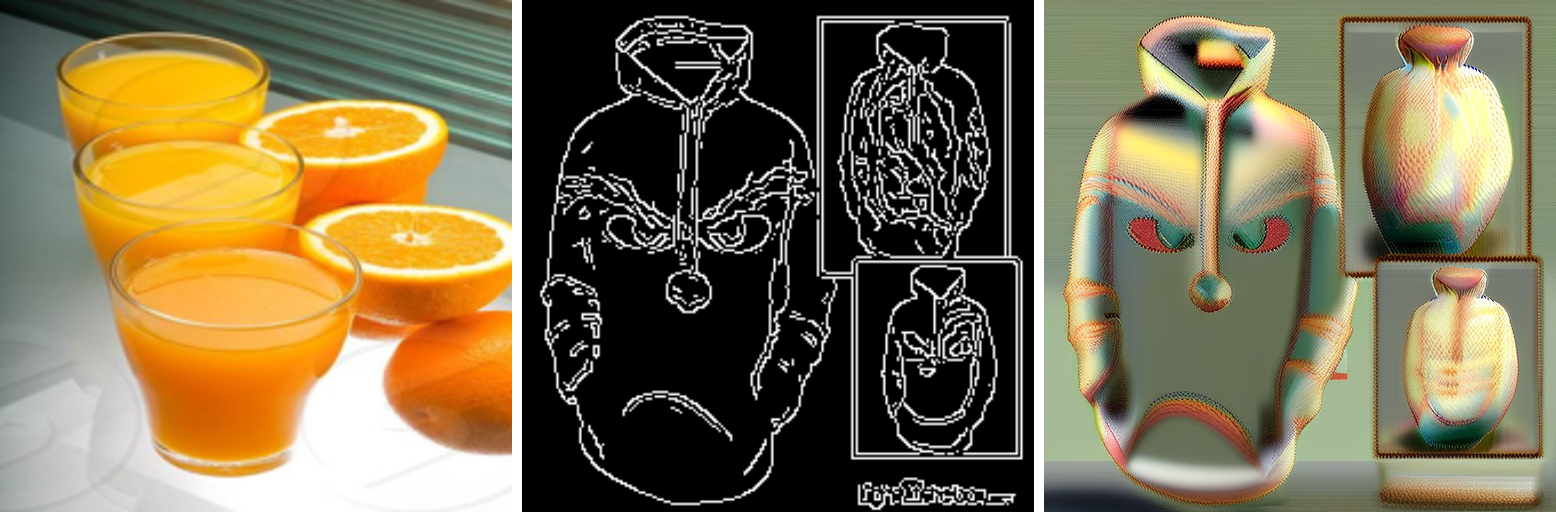

Debug get_color_embedding:
  - Input shape: torch.Size([1, 1280])
  - Logits shape: torch.Size([1, 512])
  - Probs shape: torch.Size([1, 512])
  - Color embedding shape: torch.Size([1, 1280])


  0%|          | 0/50 [00:00<?, ?it/s]

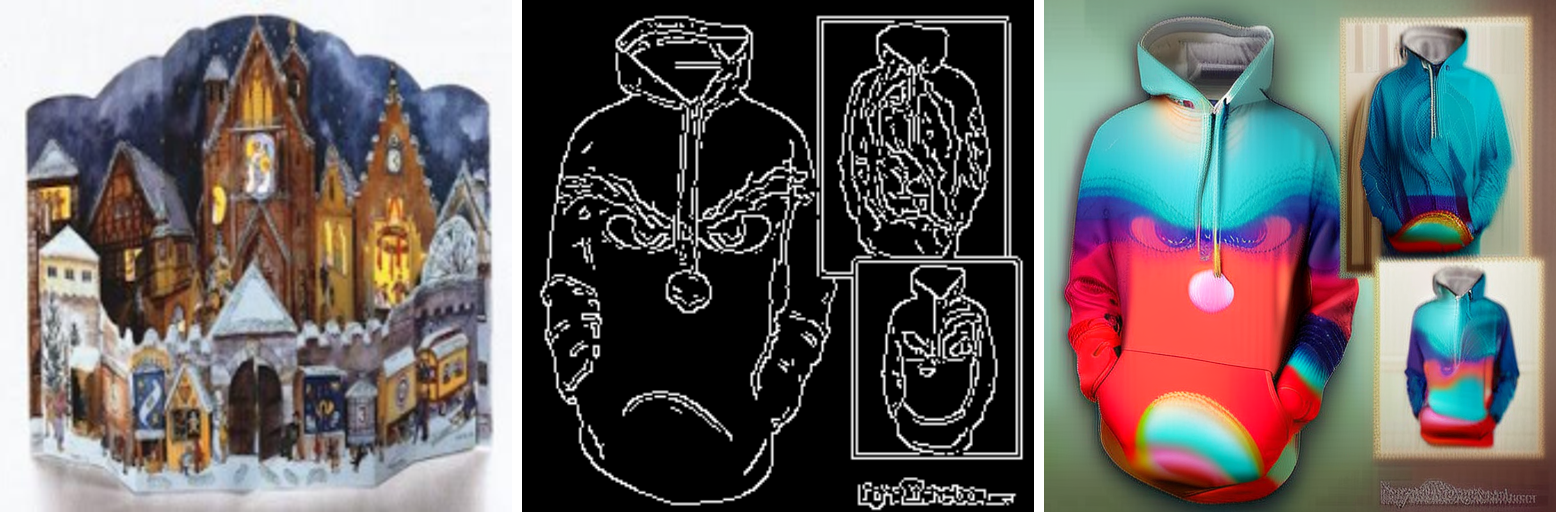

Debug get_color_embedding:
  - Input shape: torch.Size([1, 1280])
  - Logits shape: torch.Size([1, 512])
  - Probs shape: torch.Size([1, 512])
  - Color embedding shape: torch.Size([1, 1280])


  0%|          | 0/60 [00:00<?, ?it/s]

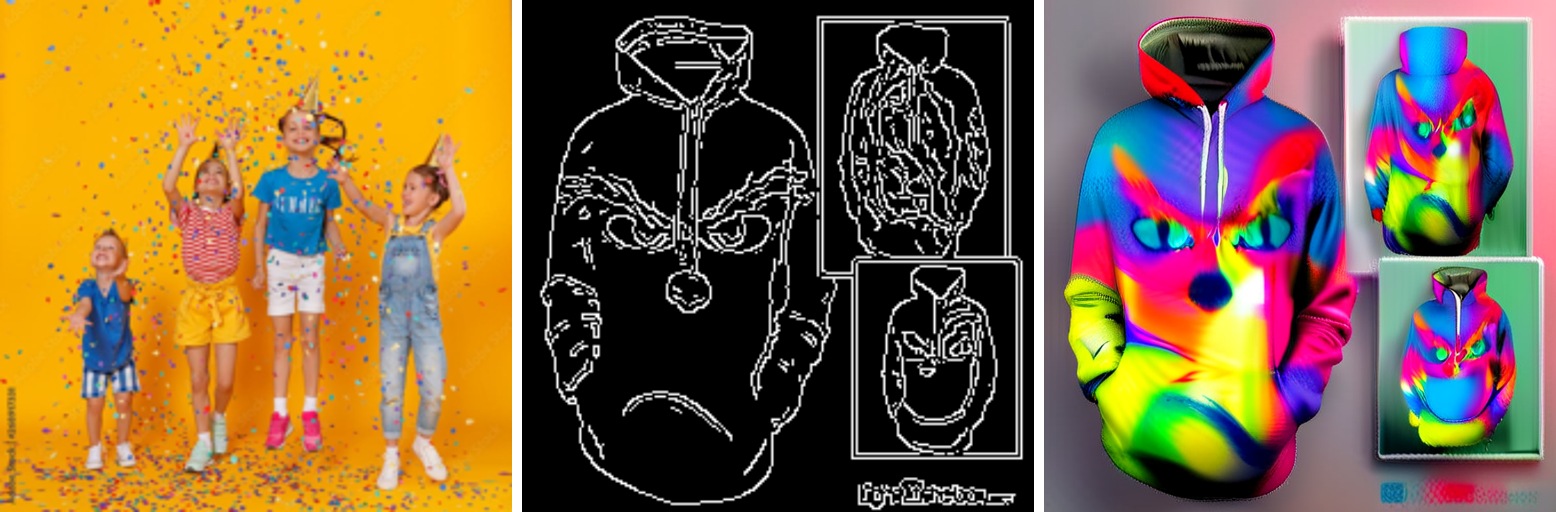

✓ High-quality image generation complete!


In [43]:
# Generate high-quality images with IP-Adapter XL
print("Generating images with IP-Adapter XL (SDXL)...")

# Example 1: Cat with ball (high quality)
images1 = generate_from_dataset_id_xl(
    colour_index=1000,
    layout_index=33,
    prompt="a cat playing with a ball, high quality, detailed",
    guidance_scale=6.5,
    steps=40,
    controlnet_conditioning_scale=0.8,
    num_samples=1,
    attn_ip_scale=0.8,
    text_token_scale=1.0,
    ip_token_scale=0.5,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

# Example 2: Dog on hoodie (artistic style)
images2 = generate_from_dataset_id_xl(
    colour_index=1008,
    layout_index=33,
    prompt="a dog on the hoodie, artistic style, professional photography",
    guidance_scale=7.5,
    steps=50,
    controlnet_conditioning_scale=0.9,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.1,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

# Example 3: Creative composition
images3 = generate_from_dataset_id_xl(
    colour_index=1003,
    layout_index=33,
    prompt="A cat on the hoodie, digital art, vibrant colors, masterpiece",
    guidance_scale=8.0,
    steps=60,
    controlnet_conditioning_scale=0.7,
    num_samples=1,
    attn_ip_scale=0.7,
    text_token_scale=1.2,
    ip_token_scale=0.6,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

print("✓ High-quality image generation complete!")


In [36]:
def calculate_emd_distance_topk(hist1: np.ndarray, hist2: np.ndarray, top_k: int = 20, blur: float = 0.01) -> float:
    """
    Calculate Earth Mover's Distance between top-k histogram values using Sinkhorn algorithm.
    
    Args:
        hist1: First histogram (normalized)
        hist2: Second histogram (normalized)
        top_k: Number of top histogram values to consider
        blur: Blur parameter for Sinkhorn algorithm
        
    Returns:
        EMD distance value
    """
    # Get top-k indices for both histograms
    top_indices_1 = np.argsort(hist1)[-top_k:]
    top_indices_2 = np.argsort(hist2)[-top_k:]
    
    # Get unique indices (union of both top-k sets)
    unique_indices = np.union1d(top_indices_1, top_indices_2)
    
    # Extract top-k values and normalize
    h1_topk = hist1[unique_indices]
    h2_topk = hist2[unique_indices]
    
    # Normalize to sum to 1
    h1_topk = h1_topk / (h1_topk.sum() + 1e-8)
    h2_topk = h2_topk / (h2_topk.sum() + 1e-8)
    
    # Convert to torch tensors and add batch dimension
    h1 = torch.tensor(h1_topk, dtype=torch.float32).unsqueeze(0)
    h2 = torch.tensor(h2_topk, dtype=torch.float32).unsqueeze(0)
    
    # Calculate EMD using Sinkhorn
    loss = geomloss.SamplesLoss("sinkhorn", p=2, blur=blur, backend="tensorized")
    emd = loss(h1, h2).item()
    
    return emd

def generate_from_dataset_id_xl_with_emd(
    colour_index: int,
    layout_index: int,
    prompt: str = "a cat playing with a ball",
    target_emd_threshold: float = 0.1,
    max_attempts: int = 20,
    top_k: int = 20,  # New parameter for top-k EMD
    guidance_scale: float = 6.5,
    steps: int = 40,
    controlnet_conditioning_scale: float = 0.8,
    num_samples: int = 1,
    attn_ip_scale: float = 0.8,
    text_token_scale: float = 1.0,
    ip_token_scale: float = None,
    ip_uncond_scale: float = 0.0,
    zero_ip_in_uncond: bool = True,
):
    """Generate images using IP-Adapter XL with EMD constraint on top-k histogram values."""
    
    # Get original image for display
    img_t, _ = colour_dataset[colour_index]
    pil_img = transforms.ToPILImage()(img_t)
    
    # Get CLIP embedding and compute color embedding
    z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
    color_embedding = degis.get_color_embedding(color_head, z_clip)
    
    # Get original histogram for EMD comparison
    original_histogram = histograms[colour_index]
    
    # Create control image from edge data
    control_image = degis.create_edge_control_image(edge_maps[layout_index], size=512)
    
    # EMD-constrained generation
    best_images = None
    best_emd = float('inf')
    attempts_made = 0
    
    print(f"Generating with EMD constraint (target: {target_emd_threshold:.3f})")
    print(f"Using prompt: '{prompt}'")
    print(f"Max attempts: {max_attempts}")
    print(f"EMD calculation: top-{top_k} histogram values")
    print("-" * 50)
    
    for attempt in range(max_attempts):
        # Generate images with IP-Adapter XL
        images = generator.generate(
            color_embedding=color_embedding,
            control_image=control_image,
            prompt=prompt,
            negative_prompt=(
                "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, "
                "sketch, cartoon, drawing, anime:1.4, comic, illustration, posterized, "
                "mosaic, stained glass, abstract, surreal, psychedelic, trippy, texture artifact, "
                "embroidery, knitted, painting, oversaturated, unrealistic, bad shading"
            ),
            num_samples=num_samples,
            guidance_scale=guidance_scale,
            num_inference_steps=steps,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            # IP-Adapter XL specific parameters
            attn_ip_scale=attn_ip_scale,
            text_token_scale=text_token_scale,
            ip_token_scale=ip_token_scale,
            ip_uncond_scale=ip_uncond_scale,
            zero_ip_in_uncond=zero_ip_in_uncond,
        )
        
        # Calculate histogram for generated image
        generated_hist = compute_color_histogram(images[0], bins=8)
        
        # Calculate EMD distance using top-k values
        emd_distance = calculate_emd_distance_topk(original_histogram, generated_hist, top_k=top_k, blur=0.01)
        
        attempts_made += 1
        
        print(f"Attempt {attempt + 1:2d}: EMD = {emd_distance:.4f}", end="")
        
        # Check if this is the best result so far
        if emd_distance < best_emd:
            best_emd = emd_distance
            best_images = images
            print(" ← NEW BEST!")
        else:
            print()
        
        # Check if we've reached the target threshold
        if emd_distance <= target_emd_threshold:
            print(f"\n✓ Target EMD reached! ({emd_distance:.4f} <= {target_emd_threshold:.3f})")
            break
    
    # Display results
    if best_images:
        comparison = degis.display_comparison_grid(
            original=pil_img,
            control=control_image,
            generated=best_images,
            cols=3
        )
        display(comparison)
        
        print(f"\n✓ Generation complete!")
        print(f"Best EMD achieved: {best_emd:.4f}")
        print(f"Attempts made: {attempts_made}")
    
    return best_images, best_emd, attempts_made

print("✓ IP-Adapter XL EMD-constrained generation function defined (top-k EMD)")

✓ IP-Adapter XL EMD-constrained generation function defined (top-k EMD)


Debug get_color_embedding:
  - Input shape: torch.Size([1, 1280])
  - Logits shape: torch.Size([1, 512])
  - Probs shape: torch.Size([1, 512])
  - Color embedding shape: torch.Size([1, 1280])
Generating with EMD constraint (target: 0.020)
Using prompt: 'a dog on the hoodie, artistic style, professional photography, online store product image'
Max attempts: 20
EMD calculation: top-20 histogram values
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  1: EMD = 0.0266 ← NEW BEST!


  0%|          | 0/100 [00:00<?, ?it/s]

Attempt  2: EMD = 0.0186 ← NEW BEST!

✓ Target EMD reached! (0.0186 <= 0.020)


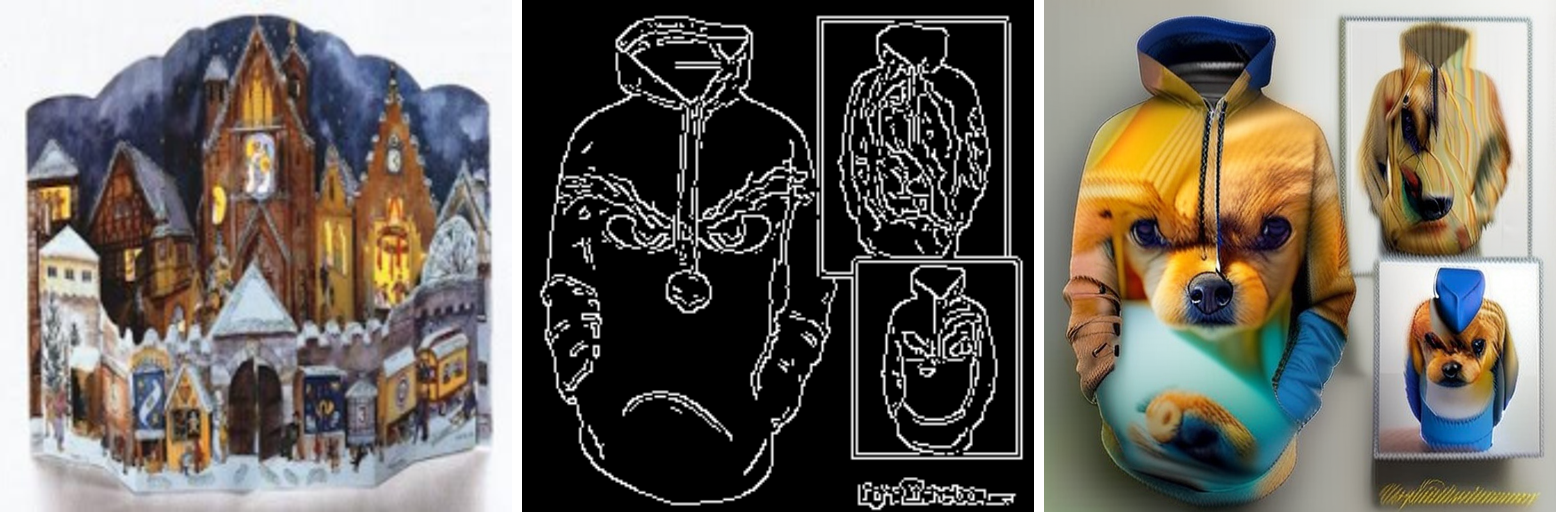


✓ Generation complete!
Best EMD achieved: 0.0186
Attempts made: 2


In [44]:
# Example 2: Dog on hoodie (artistic style)
images2 = generate_from_dataset_id_xl_with_emd(
    colour_index=1008,
    layout_index=33,
    prompt = "a dog on the hoodie, artistic style, professional photography, online store product image",
    target_emd_threshold=0.02,
    max_attempts=20,
    guidance_scale=7.5,
    steps=100,
    controlnet_conditioning_scale=0.9,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.1,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

Debug get_color_embedding:
  - Input shape: torch.Size([1, 1280])
  - Logits shape: torch.Size([1, 512])
  - Probs shape: torch.Size([1, 512])
  - Color embedding shape: torch.Size([1, 1280])
Generating with EMD constraint (target: 0.020)
Using prompt: 'a bird on the hoodie, artistic style, professional photography, online store product image'
Max attempts: 10
EMD calculation: top-20 histogram values
--------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  1: EMD = 0.0391 ← NEW BEST!


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  2: EMD = 0.0373 ← NEW BEST!


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  3: EMD = 0.0359 ← NEW BEST!


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  4: EMD = 0.0342 ← NEW BEST!


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  5: EMD = 0.0273 ← NEW BEST!


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  6: EMD = 0.1621


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  7: EMD = 0.0668


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  8: EMD = 0.0699


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt  9: EMD = 0.0582


  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 10: EMD = 0.0553


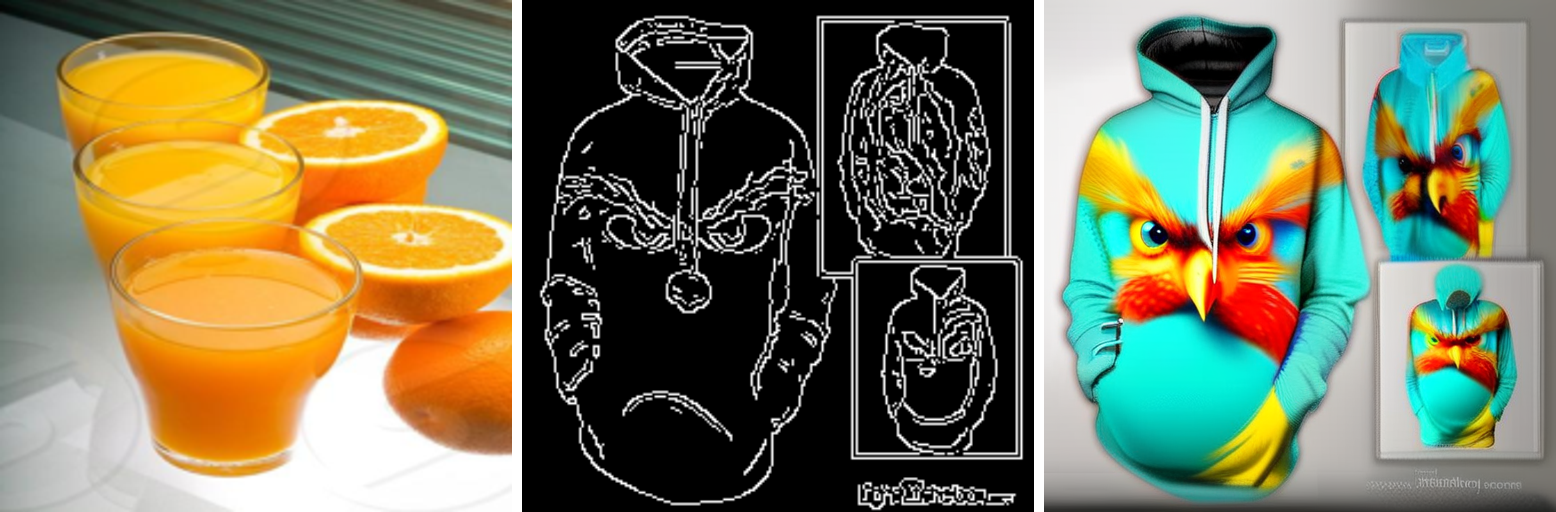


✓ Generation complete!
Best EMD achieved: 0.0273
Attempts made: 10


In [45]:
# Example 2: Dog on hoodie (artistic style)
images2 = generate_from_dataset_id_xl_with_emd(
    colour_index=1000,
    layout_index=33,
    prompt="a bird on the hoodie, artistic style, professional photography, online store product image",
    target_emd_threshold=0.02,
    max_attempts=10,
    guidance_scale=7.5,
    steps=50,
    controlnet_conditioning_scale=0.5,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.1,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

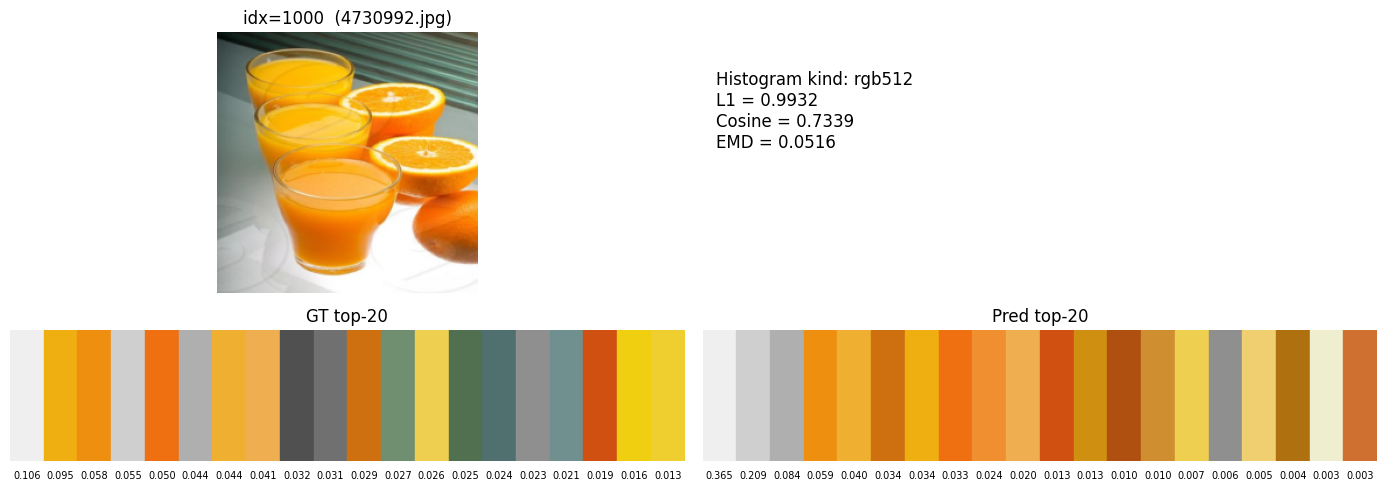

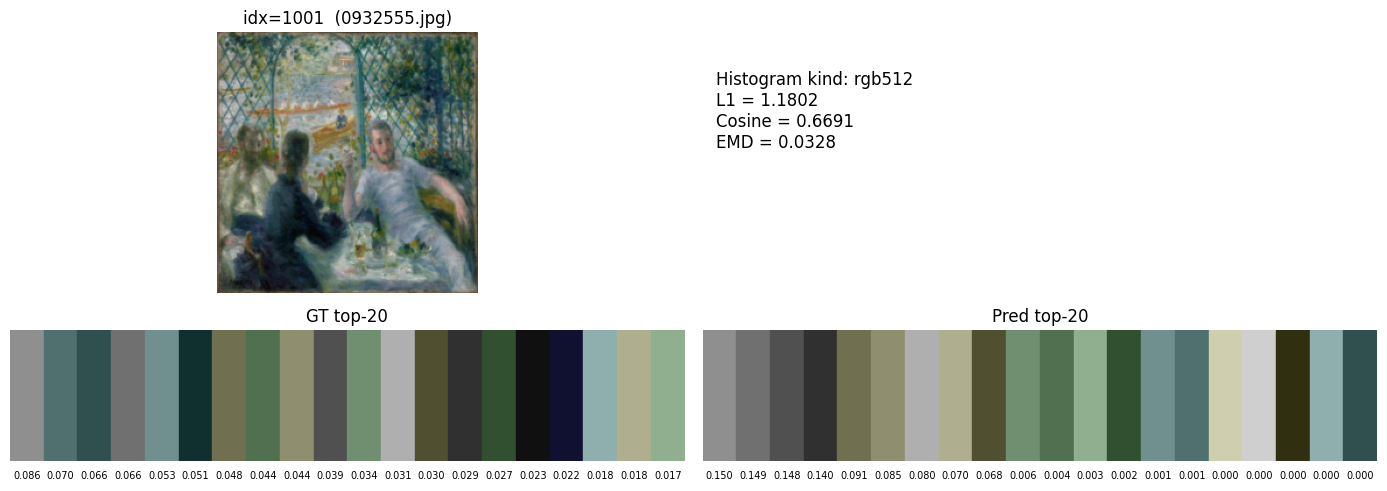

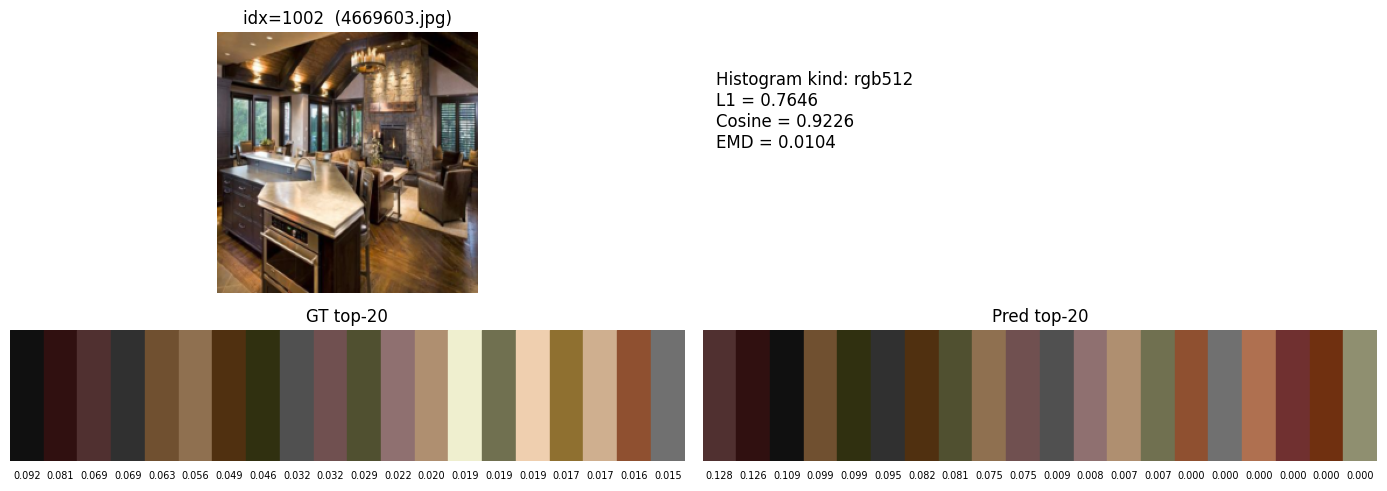

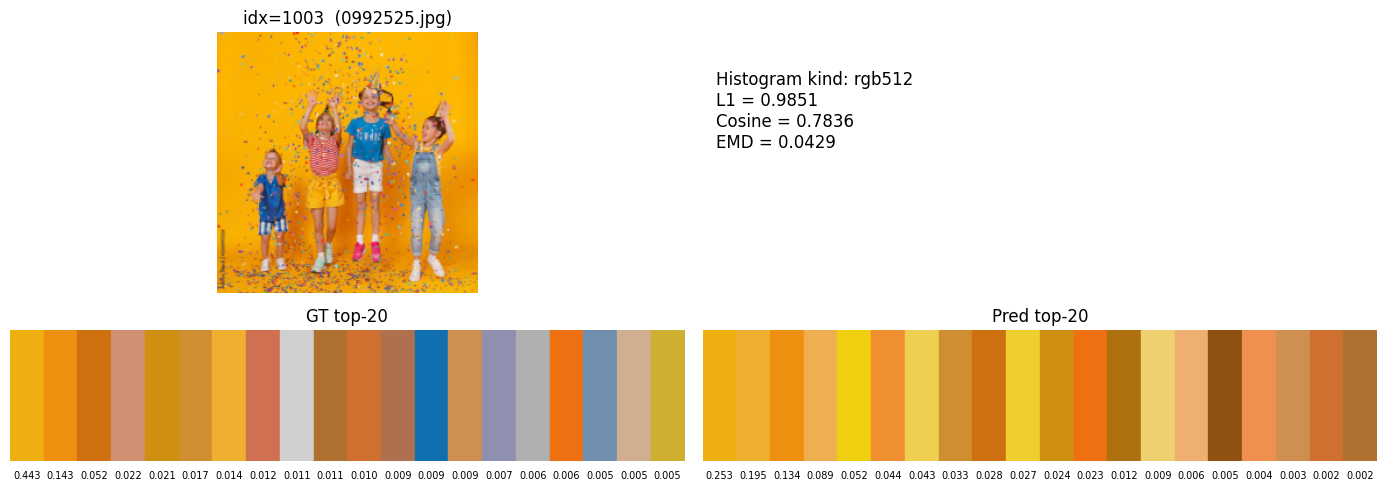

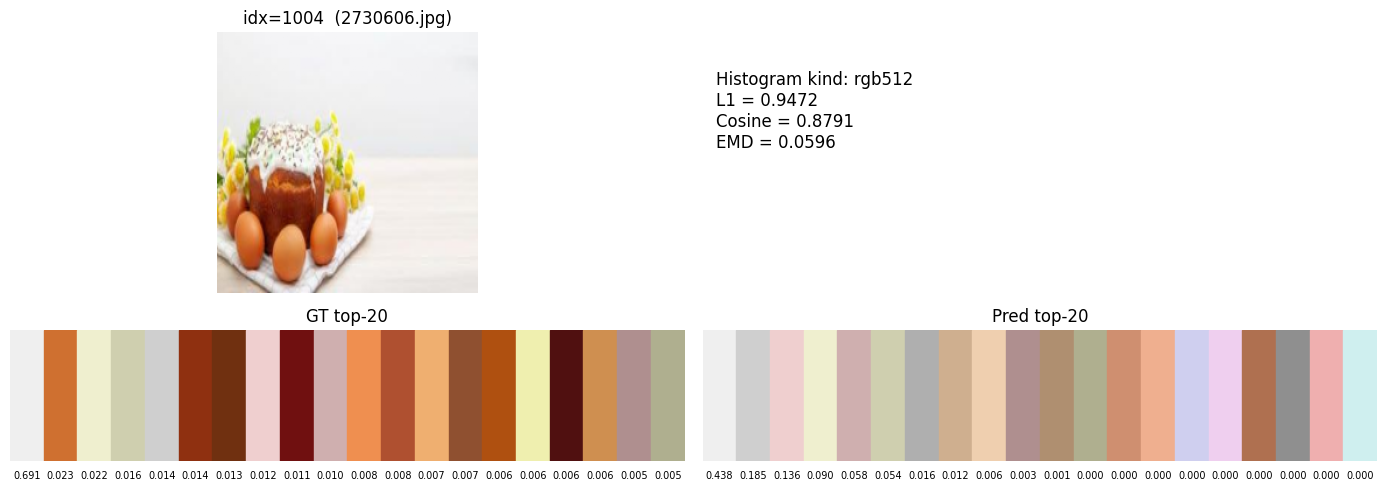

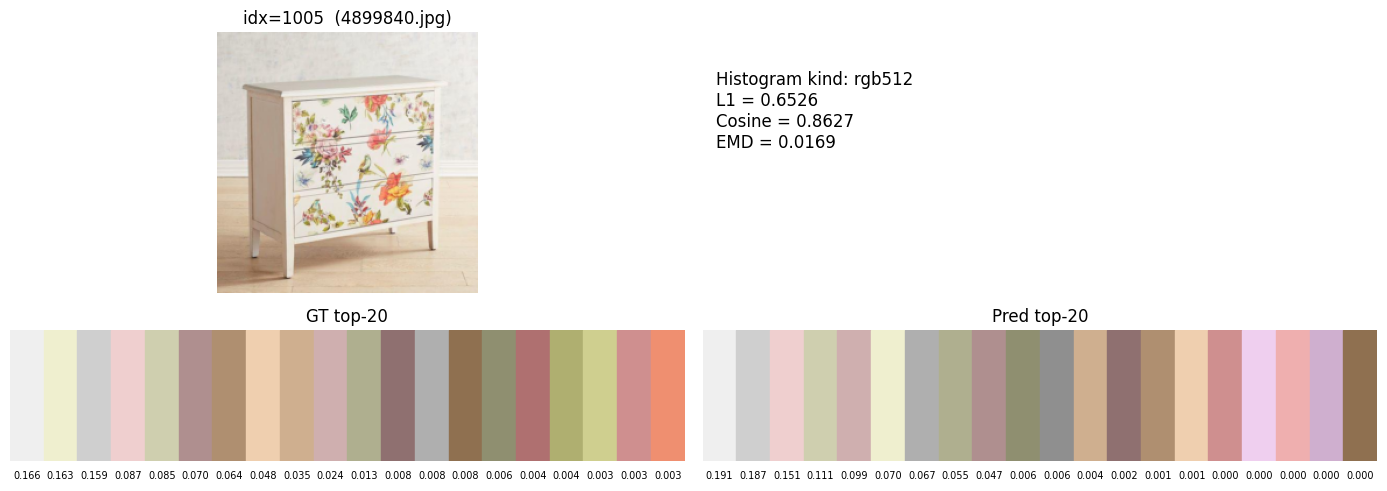

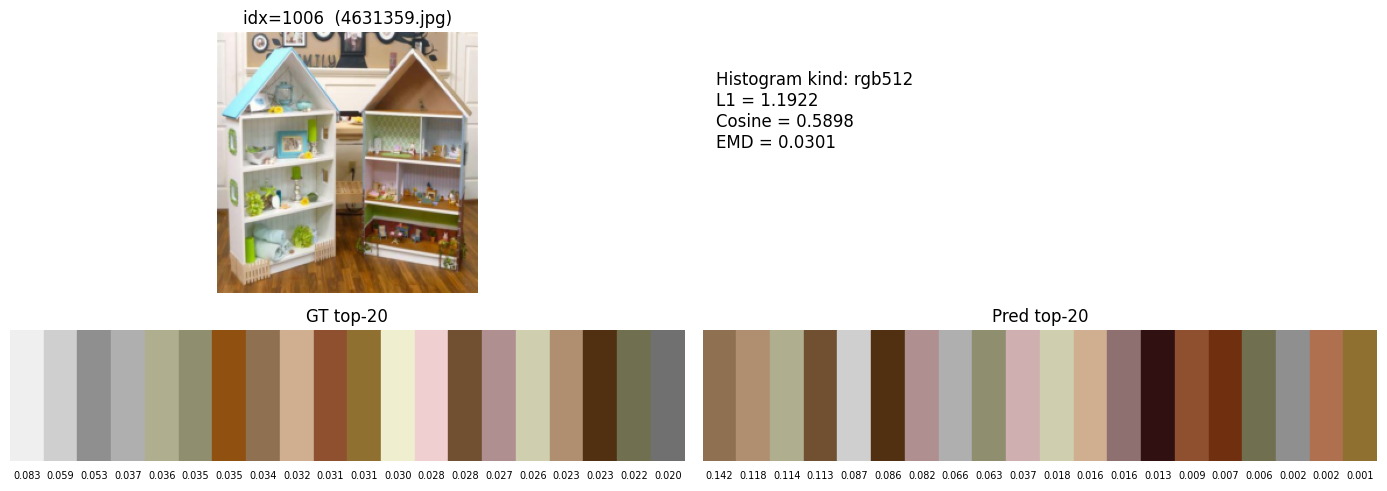

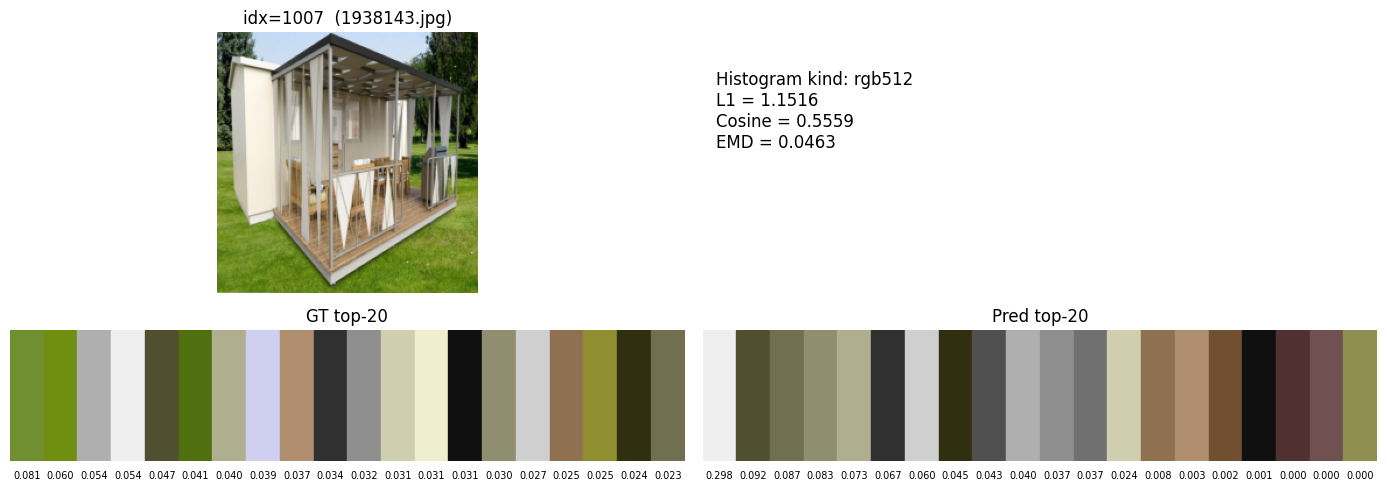

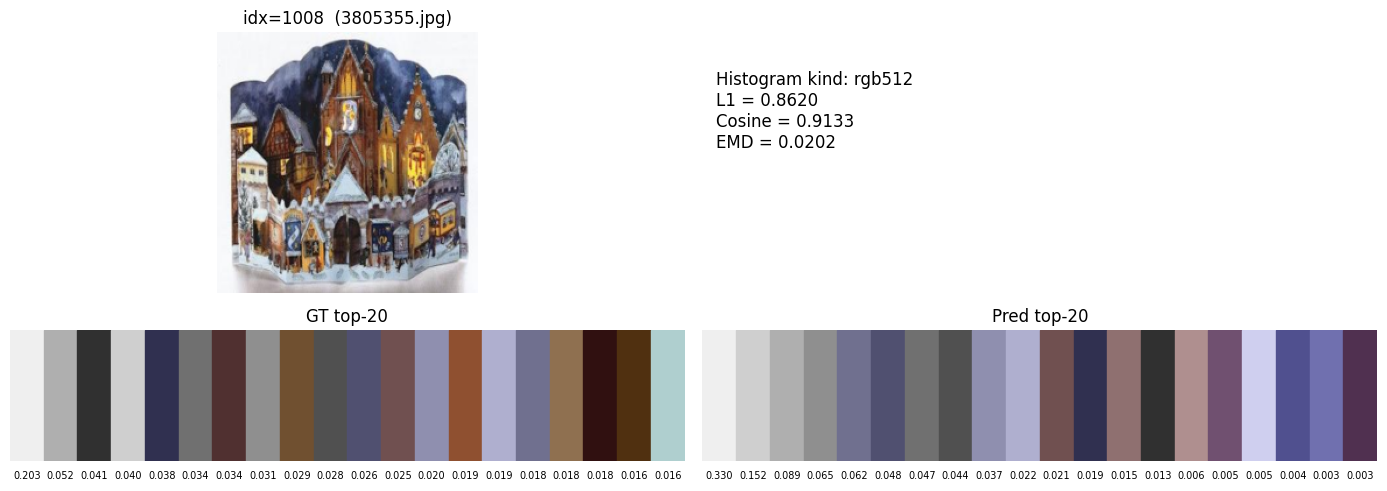

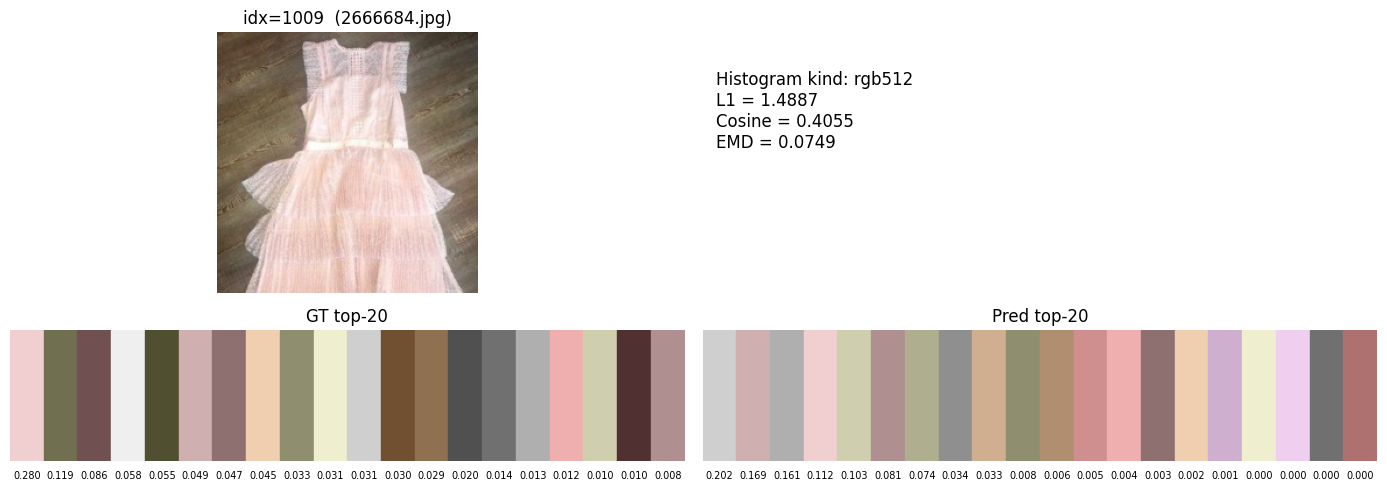

In [42]:
BINS      = 8
TOP_K     = 20
SPACE = "rgb"
hist = histograms
emb = embeddings
HIST_KIND = "rgb512"   # "rgb512" | "lab514" | "hcl514"
sinkhorn = geomloss.SamplesLoss("sinkhorn", p=2, blur=0.05, backend="tensorized")
def _top_palette(vec, bins=BINS, top_k=TOP_K, space=SPACE, c_max=150.0):
    v = vec.detach().cpu().numpy() if isinstance(vec, torch.Tensor) else np.asarray(vec)
    core = v[:bins**3]  # ignore the last 2 BW slots for palette picking
    idxs = np.argsort(core)[-top_k:][::-1]
    cols = []
    if space == "rgb":
        for flat in idxs:
            ri = flat // (bins*bins); gi = (flat // bins) % bins; bi = flat % bins
            cols.append(((ri+0.5)/bins, (gi+0.5)/bins, (bi+0.5)/bins))
    elif space == "lab":
        for flat in idxs:
            Li = flat // (bins*bins); ai = (flat // bins) % bins; bi = flat % bins
            L = (Li+0.5)/bins*100.0
            a = (ai+0.5)/bins*255.0 - 128.0
            b = (bi+0.5)/bins*255.0 - 128.0
            cols.append(tuple(lab2rgb(np.array([[[L,a,b]]]))[0,0]))
    elif space == "hcl":
        for flat in idxs:
            Li = flat // (bins*bins); Ci = (flat // bins) % bins; Hi = flat % bins
            L = (Li+0.5)/bins*100.0
            C = (Ci+0.5)/bins*c_max
            H = (Hi+0.5)/bins*360.0
            a = C*np.cos(np.deg2rad(H)); b = C*np.sin(np.deg2rad(H))
            cols.append(tuple(lab2rgb(np.array([[[L,a,b]]]))[0,0]))
    else:
        raise ValueError("space must be 'rgb' | 'lab' | 'hcl'")
    return cols, core[idxs]

def _plot_palette(ax, colors, values, title):
    for i, (c, v) in enumerate(zip(colors, values)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=c))
        ax.text(i+0.5, -0.08, f"{v:.3f}", ha="center", va="top", fontsize=7)
    ax.set_xlim(0, len(colors)); ax.set_ylim(0,1); ax.axis("off")
    ax.set_title(title, fontsize=12)

def show_aligned(i, dataset):
    # image from the SAME dataset (guarantees correct ordering)
    img_t, _ = dataset[i]                    # [3,224,224] float [0,1]
    img_np   = img_t.permute(1,2,0).numpy()  # HWC

    # GT and Pred from aligned arrays / model
    h_gt = torch.from_numpy(hist[i]).to(device)
    z    = torch.from_numpy(emb[i]).to(device).unsqueeze(0)

    with torch.no_grad():
        _, p, _ = color_head(z)
        p = p.squeeze(0)
        p = p / (p.sum() + 1e-8)
        g = h_gt / (h_gt.sum() + 1e-8)
        l1  = torch.sum(torch.abs(p-g)).item()
        cos = torch.nn.functional.cosine_similarity(p, g, dim=0).item()
        emd = sinkhorn(p.unsqueeze(0), g.unsqueeze(0)).item() if sinkhorn is not None else None

    gt_cols, gt_vals = _top_palette(g)
    pr_cols, pr_vals = _top_palette(p)

    # draw
    fig, axes = plt.subplots(2, 2, figsize=(14, 5), gridspec_kw={"height_ratios":[2,1]})
    axes[0,0].imshow(img_np); axes[0,0].axis("off")
    basename = os.path.basename(str(dataset.df.iloc[i]["file_path"]))
    axes[0,0].set_title(f"idx={i}  ({basename})")

    axes[0,1].axis("off")
    txt = f"Histogram kind: {HIST_KIND}\nL1 = {l1:.4f}\nCosine = {cos:.4f}"
    if emd is not None: txt += f"\nEMD = {emd:.4f}"
    axes[0,1].text(0.02, 0.85, txt, fontsize=12, va="top")

    _plot_palette(axes[1,0], gt_cols, gt_vals, f"GT top-{TOP_K}")
    _plot_palette(axes[1,1], pr_cols, pr_vals, f"Pred top-{TOP_K}")
    plt.tight_layout(); plt.show()

# for i in range(1000, 1010):
#     show_aligned(i, colour_dataset)
for i in range(1000, 1010):
    show_aligned(i, colour_dataset)